Libraries

In [7]:
# for images
import os, cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# custom classes for specific purposes
from processor.data_loader import DataLoader
from processor.pre_processor import DatasetPreprocessor
from processor.build_model import TransferLearningModel
# for transfer learning
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
# visual
import matplotlib.pyplot as plt

GPU

In [2]:
# Set the CUDA device order (optional)
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

# Enable GPU growth
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

Folder paths

In [3]:
data_dir = "data"
dataset_dir = os.path.join(data_dir, "dataset")
dataset_2_dir = os.path.join(data_dir, "dataset_2")

output_dir = os.path.join(data_dir, "augmented_images")
labels_path = os.path.join(data_dir, "labels", "names.json")

partition_path = os.path.join(data_dir, "partition")
train_dir = os.path.join(partition_path, 'train')
val_dir = os.path.join(partition_path, 'val')

Classes

In [4]:
preprocessor = DatasetPreprocessor(dataset_dir)
data_loader = DataLoader(dataset_dir, labels_path)

Pre-processing

In [12]:
preprocessor.rename_images()
preprocessor.augment_dataset(output_dir)
preprocessor.generate_labels(labels_path)

Transfer Learning

In [5]:
transfer_model = TransferLearningModel(train_dir=train_dir, val_dir=val_dir, batch_size=32)

20 epochs

In [8]:
history = transfer_model.train(num_epochs=20, save_filename='model/mobilenetv2_epoch20_model.h5')

Found 10960 images belonging to 23 classes.
Found 2756 images belonging to 23 classes.
Epoch 1/20
343/343 [==============================] - 309s 884ms/step - loss: 0.6276 - categorical_accuracy: 0.8877 - top-3: 0.9503 - ROC-AUC: 0.9856 - PR-AUC: 0.9412 - precision: 0.9335 - recall: 0.8562 - TP: 9384.0000 - TN: 240451.0000 - FP: 669.0000 - FN: 1576.0000 - val_loss: 0.0796 - val_categorical_accuracy: 0.9753 - val_top-3: 0.9938 - val_ROC-AUC: 0.9989 - val_PR-AUC: 0.9956 - val_precision: 0.9824 - val_recall: 0.9721 - val_TP: 2679.0000 - val_TN: 60584.0000 - val_FP: 48.0000 - val_FN: 77.0000
Epoch 2/20
343/343 [==============================] - 331s 967ms/step - loss: 0.1284 - categorical_accuracy: 0.9599 - top-3: 0.9942 - ROC-AUC: 0.9975 - PR-AUC: 0.9901 - precision: 0.9657 - recall: 0.9552 - TP: 10469.0000 - TN: 240748.0000 - FP: 372.0000 - FN: 491.0000 - val_loss: 0.0381 - val_categorical_accuracy: 0.9877 - val_top-3: 0.9964 - val_ROC-AUC: 0.9991 - val_PR-AUC: 0.9980 - val_precision: 0.

Learning Curves

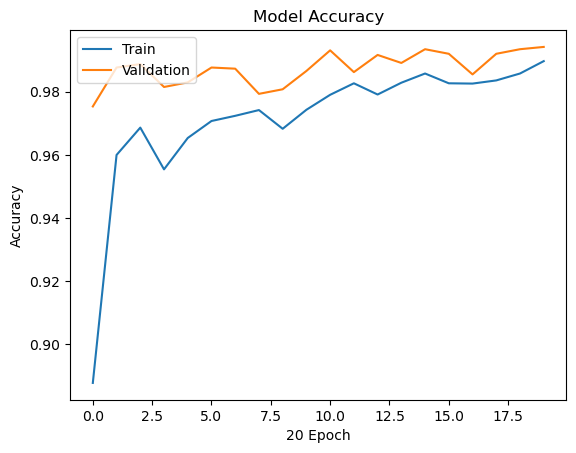

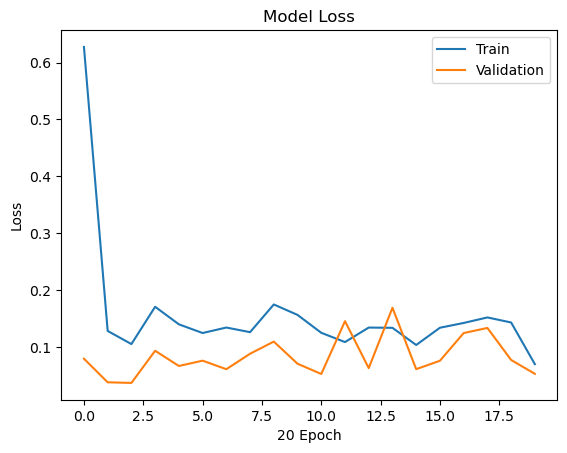

In [13]:
# Accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('20 Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('figures/accuracy_plot_20epochs.png')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('20 Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('figures/loss_plot_20epochs.png')
plt.show()

In [12]:
# Get the training and validation metrics
train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate the average metrics
avg_train_accuracy = np.mean(train_accuracy)
avg_val_accuracy = np.mean(val_accuracy)
avg_train_loss = np.mean(train_loss)
avg_val_loss = np.mean(val_loss)

# Print the average metrics
print("Average Training Accuracy:", avg_train_accuracy)
print("Average Validation Accuracy:", avg_val_accuracy)
print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)

Average Training Accuracy: 0.971519160270691
Average Validation Accuracy: 0.9874274283647537
Average Training Loss: 0.1568019799888134
Average Validation Loss: 0.08384189736098051


30 epoch

In [17]:
history_1 = transfer_model.train(num_epochs=30, save_filename='model/mobilenetv2_epoch30_model.h5')

Found 10960 images belonging to 23 classes.
Found 2756 images belonging to 23 classes.
Epoch 1/30
343/343 [==============================] - 287s 820ms/step - loss: 0.5040 - categorical_accuracy: 0.8982 - top-3: 0.9595 - ROC-AUC: 0.9862 - PR-AUC: 0.9489 - precision: 0.9324 - recall: 0.8798 - TP: 9643.0000 - TN: 240421.0000 - FP: 699.0000 - FN: 1317.0000 - val_loss: 0.0765 - val_categorical_accuracy: 0.9811 - val_top-3: 0.9942 - val_ROC-AUC: 0.9982 - val_PR-AUC: 0.9945 - val_precision: 0.9857 - val_recall: 0.9779 - val_TP: 2695.0000 - val_TN: 60593.0000 - val_FP: 39.0000 - val_FN: 61.0000
Epoch 2/30
343/343 [==============================] - 31s 89ms/step - loss: 0.1473 - categorical_accuracy: 0.9565 - top-3: 0.9928 - ROC-AUC: 0.9967 - PR-AUC: 0.9871 - precision: 0.9626 - recall: 0.9527 - TP: 10442.0000 - TN: 240714.0000 - FP: 406.0000 - FN: 518.0000 - val_loss: 0.0621 - val_categorical_accuracy: 0.9866 - val_top-3: 0.9971 - val_ROC-AUC: 0.9977 - val_PR-AUC: 0.9932 - val_precision: 0.98

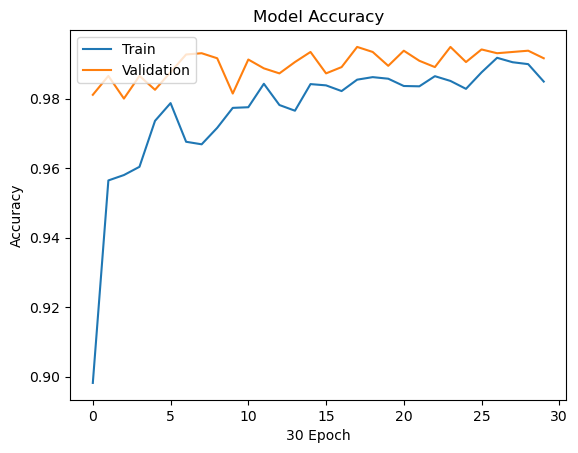

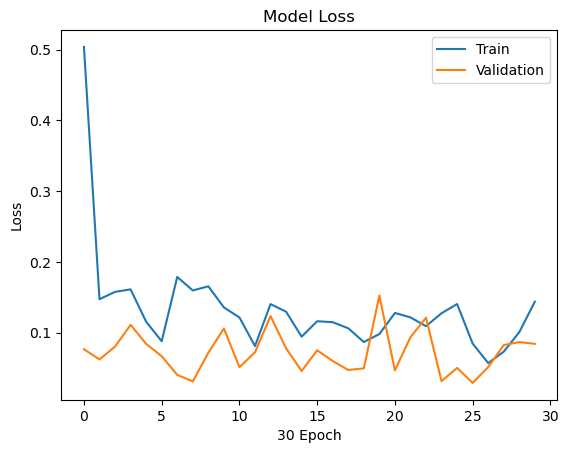

In [21]:
# Accuracy
plt.plot(history_1.history['categorical_accuracy'])
plt.plot(history_1.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('30 Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('figures/accuracy_plot_30epochs.png')
plt.show()

# Loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('30 Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('figures/loss_plot_30epochs.png')
plt.show()

In [19]:
# Get the training and validation metrics
train_accuracy = history_1.history['categorical_accuracy']
val_accuracy = history_1.history['val_categorical_accuracy']
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

# Calculate the average metrics
avg_train_accuracy = np.mean(train_accuracy)
avg_val_accuracy = np.mean(val_accuracy)
avg_train_loss = np.mean(train_loss)
avg_val_loss = np.mean(val_loss)

# Print the average metrics
print("Average Training Accuracy:", avg_train_accuracy)
print("Average Validation Accuracy:", avg_val_accuracy)
print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)

Average Training Accuracy: 0.9766605854034424
Average Validation Accuracy: 0.9898282587528229
Average Training Loss: 0.13294049724936485
Average Validation Loss: 0.07204275553425153


50 epoch

In [20]:
history_2 = transfer_model.train(num_epochs=50, save_filename='model/mobilenetv2_epoch50_model.h5')

Found 10960 images belonging to 23 classes.
Found 2756 images belonging to 23 classes.
Epoch 1/50
343/343 [==============================] - 129s 358ms/step - loss: 0.4946 - categorical_accuracy: 0.9074 - top-3: 0.9610 - ROC-AUC: 0.9867 - PR-AUC: 0.9551 - precision: 0.9381 - recall: 0.8901 - TP: 9755.0000 - TN: 240476.0000 - FP: 644.0000 - FN: 1205.0000 - val_loss: 0.0510 - val_categorical_accuracy: 0.9873 - val_top-3: 0.9967 - val_ROC-AUC: 0.9994 - val_PR-AUC: 0.9980 - val_precision: 0.9912 - val_recall: 0.9833 - val_TP: 2710.0000 - val_TN: 60608.0000 - val_FP: 24.0000 - val_FN: 46.0000
Epoch 2/50
343/343 [==============================] - 120s 350ms/step - loss: 0.1438 - categorical_accuracy: 0.9591 - top-3: 0.9944 - ROC-AUC: 0.9969 - PR-AUC: 0.9871 - precision: 0.9638 - recall: 0.9557 - TP: 10475.0000 - TN: 240727.0000 - FP: 393.0000 - FN: 485.0000 - val_loss: 0.0474 - val_categorical_accuracy: 0.9862 - val_top-3: 0.9975 - val_ROC-AUC: 0.9994 - val_PR-AUC: 0.9979 - val_precision: 0.

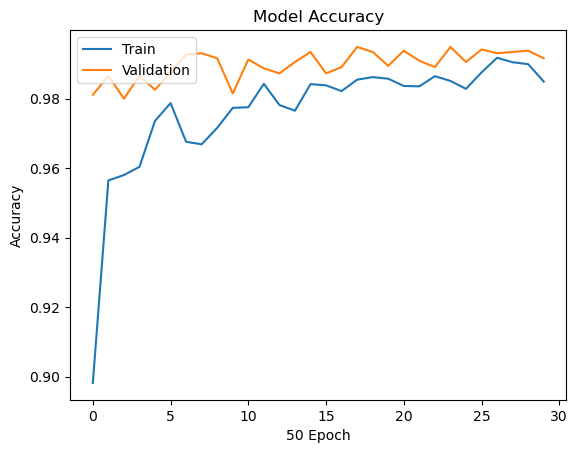

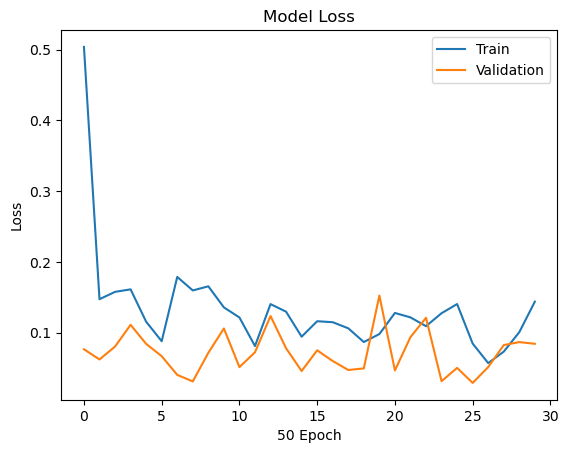

In [22]:
# Accuracy
plt.plot(history_1.history['categorical_accuracy'])
plt.plot(history_1.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('50 Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('figures/accuracy_plot_50epochs.png')
plt.show()

# Loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('50 Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('figures/loss_plot_50epochs.png')
plt.show()

In [23]:
# Get the training and validation metrics
train_accuracy = history_2.history['categorical_accuracy']
val_accuracy = history_2.history['val_categorical_accuracy']
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

# Calculate the average metrics
avg_train_accuracy = np.mean(train_accuracy)
avg_val_accuracy = np.mean(val_accuracy)
avg_train_loss = np.mean(train_loss)
avg_val_loss = np.mean(val_loss)

# Print the average metrics
print("Average Training Accuracy:", avg_train_accuracy)
print("Average Validation Accuracy:", avg_val_accuracy)
print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)

Average Training Accuracy: 0.9815346729755402
Average Validation Accuracy: 0.9903555917739868
Average Training Loss: 0.12149912104010582
Average Validation Loss: 0.08871484283357858
